In [21]:
from helpers import *
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import pandas as pd

In [27]:
### Convert from dict to df
tracks = ['nom', 'pseudo', 'ideal', 'nom_RF75', 'nom_RF75_replaceFRAGHFWithTruth',
         'nom_RF75_replaceFRAGWithTruth', 'nom_RF75_replaceHFWithTruth',
         'nom_RF75_replaceWithTruth', 'nom_replaceFRAGHFWithTruth',
         'nom_replaceFRAGWithTruth', 'nom_replaceWithTruth', 'nom_replaceHFWithTruth']
sample='427080_Zprime'
in_dir = 'jetDicts'
out_dir = 'dataFrames'
if not (os.path.isdir(out_dir)): os.makedirs(out_dir)


for track in tracks:
    filename = f'{in_dir}/{sample}_{track}_jetVars.pickle'
    with open(filename, 'rb') as handle:
        jetDict = pickle.load(handle)
    df = pd.DataFrame.from_dict(jetDict)
    df['jet_jf_m'] = df['jet_jf_m']/1000
    
    out_filename = f'{out_dir}/{sample}_{track}.pickle'
    with open(out_filename, 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
with open(f'{out_dir}/427080_Zprime_nom.pickle', 'rb') as handle:
    df = pickle.load(handle)

df.query('jet_jf_llr != -99').sort_values('jet_jf_m', ascending=False)

,jet_jf_dR,jet_jf_efc,jet_jf_llr,jet_jf_nvtx,jet_jf_ntrkAtVx,jet_jf_nvtx1t,jet_jf_sig3d,l,c,b,jet_LabDr_HadF,jet_pt,jet_jf_m,jet_jf_n2t
967400,0.011175,0.999945,-9.603395,0.0,0.0,1.0,0.179109,1952510,426028,379314,0,1304.650500,9.999937,0.0
228055,0.013807,0.999992,-2.089319,1.0,2.0,1.0,71.330734,1952510,426028,379314,5,615.952562,9.999896,3.0
1097720,0.077016,0.998819,-2.334991,0.0,0.0,2.0,13.382896,1952510,426028,379314,0,1581.148750,9.999881,7.0
292135,0.019551,0.999941,-1.700717,1.0,2.0,0.0,15.444549,1952510,426028,379314,4,556.001375,9.999763,0.0
1102043,0.041581,0.999991,-2.504152,0.0,0.0,3.0,10.520371,1952510,426028,379314,5,327.928344,9.999719,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531272,0.003653,0.030899,-5.023587,0.0,0.0,1.0,0.221257,1952510,426028,379314,5,935.723062,0.140813,0.0
900612,0.056720,0.003362,-4.799354,0.0,0.0,1.0,0.771326,1952510,426028,379314,0,413.672219,0.140746,5.0
1022208,0.078673,0.007071,-5.431805,0.0,0.0,1.0,0.038193,1952510,426028,379314,4,329.656875,0.140542,0.0
723705,0.044293,0.004497,-5.633605,0.0,0.0,1.0,0.047921,1952510,426028,379314,0,192.502922,0.140316,0.0


In [29]:
jet_vars = {
            'jet_jf_sig3d': [0, 30, 100, "Weighted flight length sig."],
            'jet_jf_m': [0, 10, 100, 'Invariant mass of tracks from displaced vertices [GeV]'],
            'jet_jf_efc': [0, 1, 100, 'Energy fraction'],
        }

In [30]:
class JFPlots:
    def __init__(self, tracks, var, var_list, ylabel='Arbitrary units', sample='427080_Zprime',
                 in_dir='dataFrames', out_dir='JFPlots'):
        self.tracks = tracks
        self.sample = sample
        self.in_dir = in_dir
        self.out_dir = out_dir
        if not (os.path.isdir(self.out_dir)): os.makedirs(self.out_dir)
        
        self.var = var
        self.xmin, self.xmax, self.xbins, self.var_label = var_list
        self.ylabel = ylabel
        
        self.track_styles = {
            'nom': ["#000000", "Nominal"],
            'pseudo': ["#17becf", "Pseudo"],
            'ideal': ["#ff7f0e", "Ideal"],
            
            'nom_replaceWithTruth': ["#9467bd", "Nominal, replace HF with pseudo"],
            'nom_replaceHFWithTruth': ["#9467bd", "Nominal, replace HF with pseudo"],
            'nom_replaceFRAGWithTruth': ["#7f7f7f", "Nominal, replace HF with pseudo"],
            'nom_replaceFRAGHFWithTruth': ["#bcbd22", "Nominal, replace FRAG+HF with pseudo"],
            
            'nom_RF75': ["#2ca02c", "Nominal, no fakes (TMP > 0.75)"],
            'nom_RF75_replaceWithTruth': ["#2ca02c", "Nominal, no fakes (TMP > 0.75)"],
            'nom_RF75_replaceHFWithTruth': ["#2ca02c", "Nominal, no fakes (TMP > 0.75)"],
            'nom_RF75_replaceFRAGWithTruth': ["#d62728", "Nominal, no fakes (TMP > 0.75), replace with pseudo"],
            'nom_RF75_replaceFRAGHFWithTruth': ["#2ca02c", "Nominal, no fakes (TMP > 0.75)"], 
        }
        
        
    def configure_plots(self, width=600, height=550, label_size=9, my_dpi=100):
        plt.rcParams['pdf.fonttype'] = 42
        plt.rcParams['xtick.labelsize'] = label_size 
        plt.rcParams['ytick.labelsize'] = label_size 
        plt.rcParams['axes.labelsize'] = label_size 
        fig = plt.figure(figsize=(600/my_dpi, 550/my_dpi), dpi=my_dpi)
        
        gs = gridspec.GridSpec(2,1 , height_ratios=[4,1])
        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])
        fig.subplots_adjust(hspace=0.07)
        fig.align_ylabels()
        
        # Settings for x and y axes
        ax1.xaxis.set_visible(False)
        ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax1.set_ylabel(self.ylabel, horizontalalignment='right', y=1.0)
        ax1.set_xlim([self.xmin, self.xmax])
        
        ax2.set_ylabel("Ratio", horizontalalignment='right', y=1.0)
        ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax2.set_xlabel(self.var_label, horizontalalignment='right', x=1.0)
        ax2.set_xlim([self.xmin, self.xmax])
        ax2.set_xticks(range(self.xmin, self.xmax))
        ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax2.xaxis.set_major_locator(ticker.MaxNLocator())
        if '_n' in var:
            ax2.set_xticks(np.arange(self.xmin+0.5, self.xmax+0.5,1), minor=True)
            ax2.set_xticklabels(np.arange(self.xmin, self.xmax), minor=True)
            ax2.set_xticklabels([])
            ax2.set_xticks([])
        
        return ax1, ax2
    
    
    def get_ratio(self, hist1, hist2):
        hist = []
        for i in range(len(hist1)):
            if hist2[i] == 0:
                if hist1[i] == 0: value = 1
                else: value = 0
            else: value = hist1[i]/hist2[i]
            hist.append(value)

        return hist
        
    
    def plot_vars(self, baseline_track):
        filename = self.var
        ax1, ax2 = self.configure_plots()
        ymaxs = []
    
        for track in self.tracks:
            filename += '_' + track
            with open(f'{self.in_dir}/427080_Zprime_{track}.pickle', 'rb') as handle:
                df = pickle.load(handle)
            
            if track == baseline_track:
                baseline = df.query('jet_jf_llr != -99')[self.var]
            
            values = df.query('jet_jf_llr != -99')[self.var]
            
            y, x, _ = ax1.hist(values, bins=self.xbins,
                               range=(self.xmin, self.xmax), density=True, color=self.track_styles[track][0],
                               histtype='step', label=self.track_styles[track][1])
            ymaxs.append(y.max())
            #print(y.max())
            
            # Get ratio
            hist_base, bin_edges = np.histogram(baseline, bins=self.xbins, range=(self.xmin, self.xmax), density=True)
            hist, bin_edges = np.histogram(values, bins=self.xbins, range=(self.xmin, self.xmax), density=True)
            ratio = self.get_ratio(hist, hist_base)
            
            # Plot ratios
            left,right = bin_edges[:-1],bin_edges[1:]
            X = np.array([left,right]).T.flatten()
            Y = np.array([ratio,ratio]).T.flatten()
            ax2.plot(X,Y, color=self.track_styles[track][0], linewidth=1)
        
        ax1.set_ylim([0, max(ymaxs)*1.35])
        handles, labels = ax1.get_legend_handles_labels()
        new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles] # Draw lines for legend
        ax1.legend(loc='best', labelspacing=0.3, handles=new_handles, labels=labels, facecolor='none', edgecolor='none')
        
        plt.savefig(f'{self.out_dir}/{filename}.pdf', bbox_inches='tight', pad_inches=0.04)
        
            

0.23236566465084116
0.2805356199707957
0.2666146295131495
0.4686387596899226
0.5385262219794594
0.5108851709689708
3.6204651162790698
5.1513953672227055
5.587330422807583


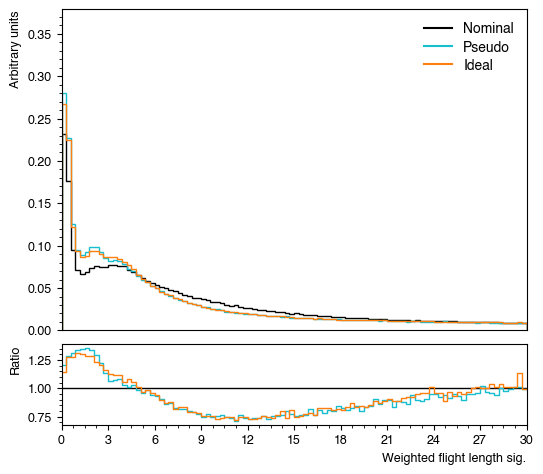

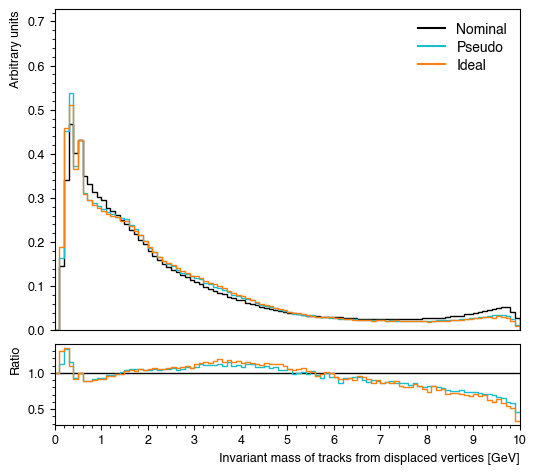

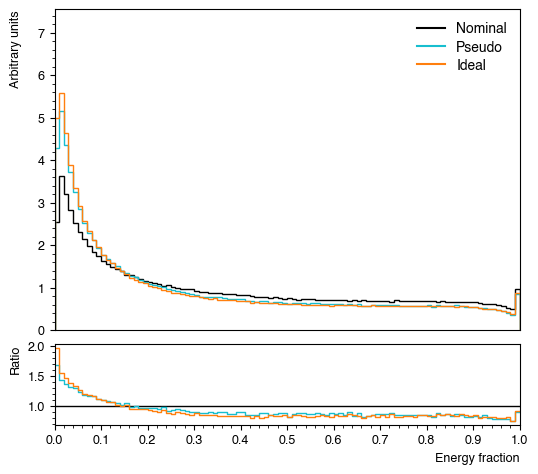

In [31]:
for var in jet_vars.items():
    JFPlots(['nom', 'pseudo', 'ideal'], var[0], var[1]).plot_vars('nom')